In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
import plotly.express as px
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('https://github.com/tzekiattok/strokedata/blob/main/healthcare-dataset-stroke-data.csv?raw=true')

In [ ]:
df.info()
#let stroke the the label, (0,1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
residence_type = df['Residence_type'].unique()
ever_married = df['ever_married'].unique()
le = LabelEncoder()

le.fit(residence_type)
df['Residence_type'] = le.transform(df['Residence_type'])

le.fit(ever_married)
df['ever_married'] = le.transform(df['ever_married'])

In [4]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [5]:
df_encoded = df
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['work_type'], prefix = 'work_type=')], axis = 1).drop(['work_type'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['smoking_status'], prefix = 'smoking_status=')], axis = 1).drop(['smoking_status'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['gender'], prefix = 'gender=')], axis = 1).drop(['gender'], axis = 1)
df_encoded.info()
'''
X = df_encoded.iloc[:, 1:-1].values
y = df_encoded.iloc[:, -1].values
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers= [('encoder', OneHotEncoder(), [0,5,9])], remainder= 'passthrough')
X = np.array(ct.fit_transform(X))
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 15] = le.fit_transform(X[:, 15])
X[:, 16] = le.fit_transform(X[:, 16])
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               5110 non-null   int64  
 1   age                              5110 non-null   float64
 2   hypertension                     5110 non-null   int64  
 3   heart_disease                    5110 non-null   int64  
 4   ever_married                     5110 non-null   int64  
 5   Residence_type                   5110 non-null   int64  
 6   avg_glucose_level                5110 non-null   float64
 7   bmi                              5110 non-null   float64
 8   stroke                           5110 non-null   int64  
 9   work_type=_Govt_job              5110 non-null   uint8  
 10  work_type=_Never_worked          5110 non-null   uint8  
 11  work_type=_Private               5110 non-null   uint8  
 12  work_type=_Self-empl

"\nX = df_encoded.iloc[:, 1:-1].values\ny = df_encoded.iloc[:, -1].values\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\nct = ColumnTransformer(transformers= [('encoder', OneHotEncoder(), [0,5,9])], remainder= 'passthrough')\nX = np.array(ct.fit_transform(X))\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\nX[:, 15] = le.fit_transform(X[:, 15])\nX[:, 16] = le.fit_transform(X[:, 16])\n"

In [6]:
df1 = df_encoded
df1.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type=_Govt_job,work_type=_Never_worked,work_type=_Private,work_type=_Self-employed,work_type=_children,smoking_status=_Unknown,smoking_status=_formerly smoked,smoking_status=_never smoked,smoking_status=_smokes,gender=_Female,gender=_Male,gender=_Other
0,9046,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0,0,1,0,0,0,1,0
1,51676,61.0,0,0,1,0,202.21,29.879487,1,0,0,0,1,0,0,0,1,0,1,0,0
2,31112,80.0,0,1,1,0,105.92,32.500000,1,0,0,1,0,0,0,0,1,0,0,1,0
3,60182,49.0,0,0,1,1,171.23,34.400000,1,0,0,1,0,0,0,0,0,1,1,0,0
4,1665,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,1,0,0,0,1,0,1,0,0


In [ ]:
df1['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

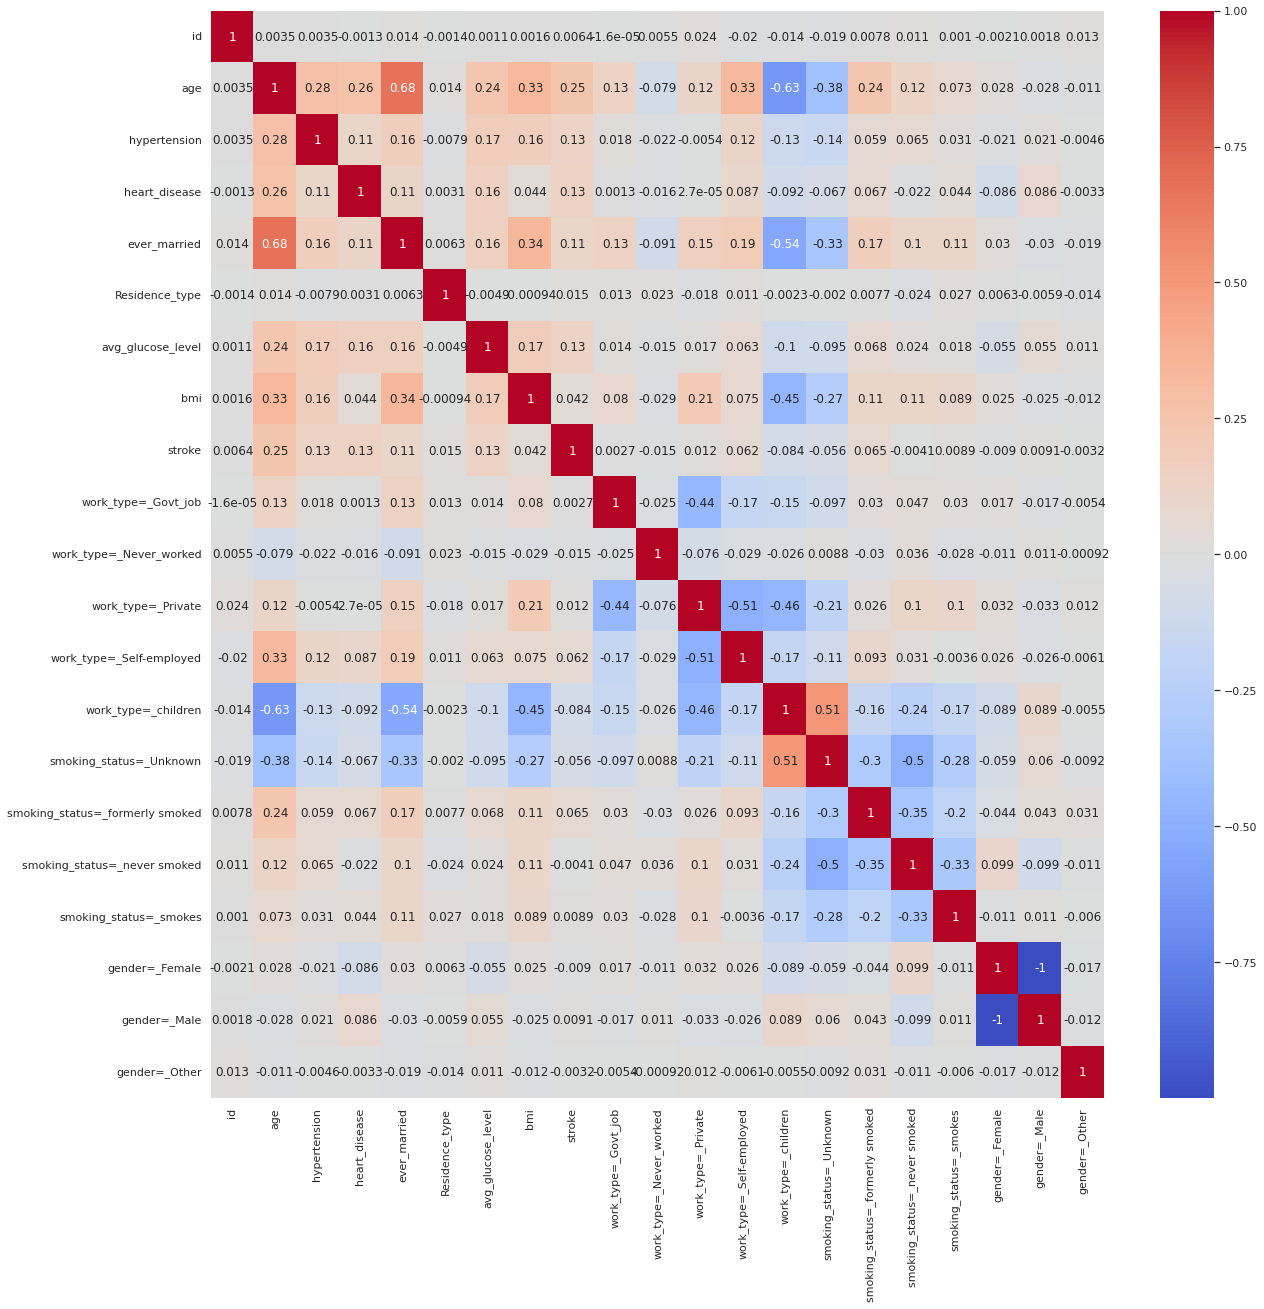

In [ ]:
corr = df1.corr()
plt.figure(figsize = (20,20))
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.show()

In [7]:
# imblearn oversampling

# import library
X = df1[['age', 'hypertension', 'heart_disease','ever_married','Residence_type', 'avg_glucose_level', 'bmi', 'work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male','gender=_Other']]
y = df1['stroke']
Columns = ['age', 'hypertension', 'heart_disease','ever_married','Residence_type', 'avg_glucose_level', 'bmi', 'work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male','gender=_Other']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              5110 non-null   float64
 1   hypertension                     5110 non-null   int64  
 2   heart_disease                    5110 non-null   int64  
 3   ever_married                     5110 non-null   int64  
 4   Residence_type                   5110 non-null   int64  
 5   avg_glucose_level                5110 non-null   float64
 6   bmi                              5110 non-null   float64
 7   work_type=_Govt_job              5110 non-null   uint8  
 8   work_type=_Never_worked          5110 non-null   uint8  
 9   work_type=_Private               5110 non-null   uint8  
 10  work_type=_Self-employed         5110 non-null   uint8  
 11  work_type=_children              5110 non-null   uint8  
 12  Residence_type      

# Scaling variables

In [8]:

from collections import Counter
from sklearn.preprocessing import StandardScaler 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 424)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


iso = IsolationForest(contamination=0.1, random_state=424)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]


#When you use any sampling technique (specifically synthetic) you divide your data first and then apply synthetic sampling on the training data only. After you do the training, you use the test set (which contains only original samples) to evaluate.
#print('Original dataset shape', Counter(y))
#print('Resample dataset shape', Counter(y_smote))
#X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=424)

# Apply Oversampling

In [9]:
ros = RandomOverSampler(random_state=424)
X_train_ros, y_train_ros =  ros.fit_resample(X_train, y_train.ravel())

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [11]:
#Tuning the models using GridSearchCV
from sklearn.model_selection import GridSearchCV

In [12]:

model = XGBClassifier()

model.fit(X_train_ros, y_train_ros)
y_pred = model.predict(X_test)

conf_matrix_XG = confusion_matrix(y_test, y_pred )
accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 
accuracies = cross_val_score(estimator = model, X = X_train_ros, y = y_train_ros, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
print(conf_matrix_XG, '\n Accuracy:',
          accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score,'\n Kfold validation:',accuracies,'\n ROC AUC Score:',roc)


[[714 255]
 [ 14  39]] 
 Accuracy: 0.7367906066536204 
 Precision: 0.1326530612244898 
 Recall: 0.7358490566037735 
 f1_score: 0.22478386167146974 
 Kfold validation: [0.86158192 0.8799435  0.87288136 0.88276836 0.88841808 0.8799435
 0.87711864 0.88276836 0.87711864 0.87429379] 
 ROC AUC Score: 0.7363455809334658


In [13]:
params = {
    'max_depth' : [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.7],
    'subsample' : [0.7,0.8,0.9,1]
}

xgbr = XGBClassifier(seed = 20)

clf = GridSearchCV(estimator = xgbr, param_grid=params, scoring='roc_auc', cv=10)

clf.fit(X_train_ros, y_train_ros)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.7}
Lowest RMSE:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in double_scalars



# Params used

Using {'colsample_bytree' : 0.7, 'learning_rate' : 0.1, 'max_depth' : 10, 'eval_metric' : 'error'}

In [14]:
params = {'colsample_bytree' : 0.7, 'learning_rate' : 0.1, 'max_depth' : 10, 'subsample': 0.7, 'eval_metric' : 'auc', 'random_state' : 424}
classifier = XGBClassifier(**params)

Accuracy: 0.9324853228962818 
Precision: 0.2777777777777778 
Recall: 0.18867924528301888 
f1_score: 0.2247191011235955 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       969
           1       0.28      0.19      0.22        53

    accuracy                           0.93      1022
   macro avg       0.62      0.58      0.59      1022
weighted avg       0.92      0.93      0.93      1022

ROC AUC score: 0.8199271764316451
Accuracy Score:  0.9324853228962818
Balanced Accuracy Score:  0.5809237299686508


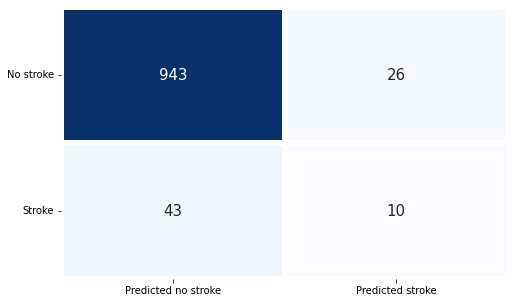

Text(0.5, 0, 'False Positive Rate')

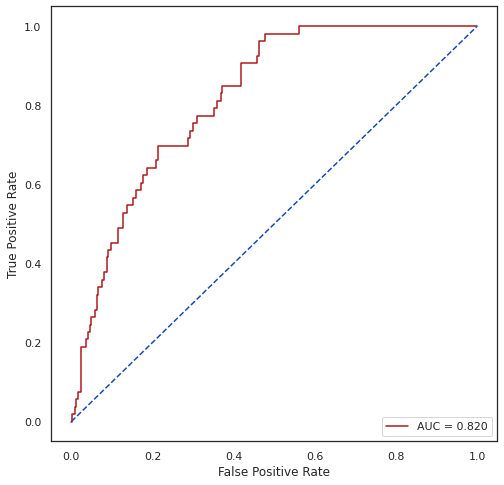

In [15]:
#Fitting XGBClassifier Model


classifier.fit(X_train_ros, y_train_ros)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]


accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 
print('Accuracy:',
      accuracy,'\nPrecision:',  precision,'\nRecall:',  recall,'\nf1_score:',  f1_score, '\n')

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('Balanced Accuracy Score: ',balanced_accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')